In [2]:
import pandas as pd
import math
import glob
import matplotlib.pyplot as plt

In [66]:
def process_snap(directory):
    total = []

    for file in glob.glob(directory + '/*.xls'):
        year = pd.read_excel(file, sheet_name=None, skiprows=4)
        total.append(process_national(year, True)) #process_year_old(year))

    for file in glob.glob(directory + '/*.xlsx'):
        year = pd.read_excel(file, sheet_name=None, skiprows=6)
        total.append(process_national(year, False))
    
    return pd.concat(total, axis=0, ignore_index=True)

def process_national(year_data, old):
    ret = []
    for region in year_data:
        if 'US' in region:
            data = year_data[region]
            if old:
                column_set = ['Date', 'Households', 'Persons', 'Benefit / Households', 'Benefit / Persons', 'Cost']
            else:
            
                column_set = ['Date', 'Households', 'Persons', 'Cost', 'Benefit / Households', 'Benefit / Persons']
            
            data.columns = column_set

            data.dropna(subset=['Date'], inplace=True)
            data = data[data['Date'].str.contains('Total') == False].to_numpy().tolist()
            

            i = 1
            current_state = data[0][0]
            while i < len(data):
                if data[i][1] == '--':
                    i += 1
                    continue

                if math.isnan(data[i][1]):
                    current_state = data[i][0]
                    i += 1
                    continue
                row = data[i] + [current_state]
                ret.append(row)
                i += 1
    
    ret = pd.DataFrame(ret, columns=column_set + ['State']) 
    ret['Date'] = pd.to_datetime(ret['Date'])
    ret.sort_values(by='Date', inplace=True)
    return ret


def process_year_old(year_data):
    ret = []
    for region in year_data:
        if 'US' not in region:
            data = year_data[region]
            data.columns = ['Date', 'Households', 'Persons', 'Benefit / Households', 'Benefit / Persons', 'Cost']
            data.dropna(subset=['Date'], inplace=True)
            data = data[data['Date'].str.contains('Total') == False].to_numpy().tolist()
            region = region.strip()

            i = 1
            current_state = data[0][0]
            while i < len(data) and data[i][0] != region:
                if data[i][1] == '--':
                    i += 1
                    continue

                if math.isnan(data[i][1]):
                    current_state = data[i][0]
                    i += 1
                    continue
                row = data[i] + [current_state] + [region]
                ret.append(row)
                i += 1
    ret = pd.DataFrame(ret, columns=['Date', 'Households', 'Persons', 'Benefit / Households', 'Benefit / Persons', 'Cost', 'State', 'Region']).dropna()
    ret['Date'] = pd.to_datetime(ret['Date'])
    return ret

def process_year_new(year_data):
    ret = []
    for region in year_data:
        if 'US' not in region:
            data = year_data[region]
            data.columns = ['Date', 'Households', 'Persons', 'Cost', 'Benefit / Households', 'Benefit / Persons']
            data.dropna(subset=['Date'], inplace=True)
            data = data[data['Date'].str.contains('Total') == False].to_numpy().tolist()
            

            i = 1
            current_state = data[0][0]
            while i < len(data) and data[i][0] != region:
                if data[i][1] == '--':
                    i += 1
                    continue

                if math.isnan(data[i][1]):
                    current_state = data[i][0]
                    i += 1
                    continue
                row = data[i] + [current_state] + [region]
                ret.append(row)
                i += 1
    ret = pd.DataFrame(ret, columns=['Date', 'Households', 'Persons', 'Cost', 'Benefit / Households', 'Benefit / Persons', 'State', 'Region']).dropna()
    ret['Date'] = pd.to_datetime(ret['Date'])
    return ret



In [74]:
national_snap = process_snap('../SNAP_data')
national_snap.sort_values(by='Date', inplace=True)
national_snap.set_index('Date', inplace=True)
national_snap.to_csv('national_snap.csv')

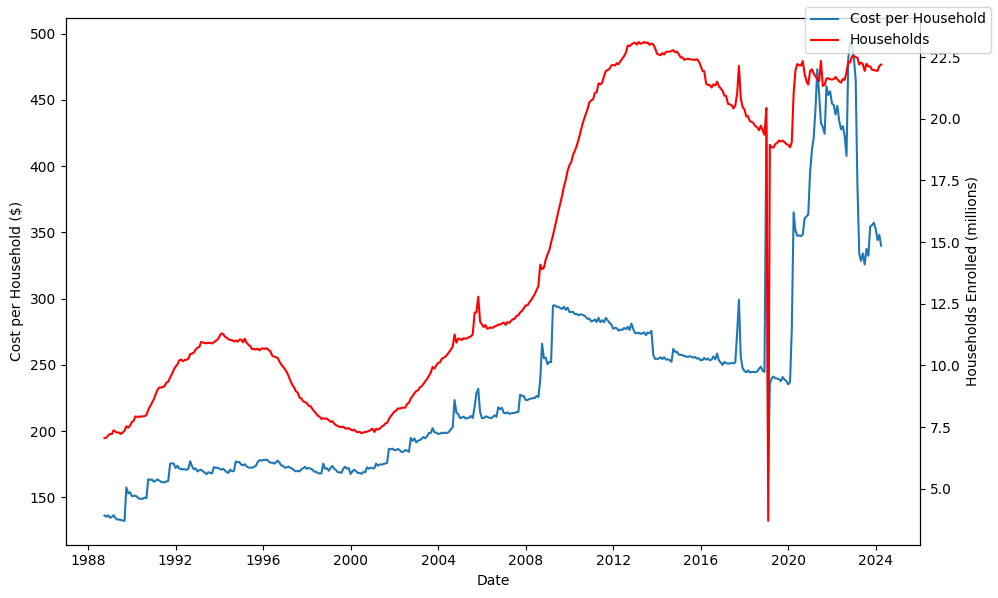

In [81]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(national_snap.index, national_snap['Benefit / Households'], label = 'Cost per Household')
ax1.set_ylabel('Cost per Household ($)')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(national_snap.index, national_snap['Households'] / 1e6, label = 'Households', color='red')

ax2.set_ylabel('Households Enrolled (millions)')

fig.legend()
fig.tight_layout()
plt.show()

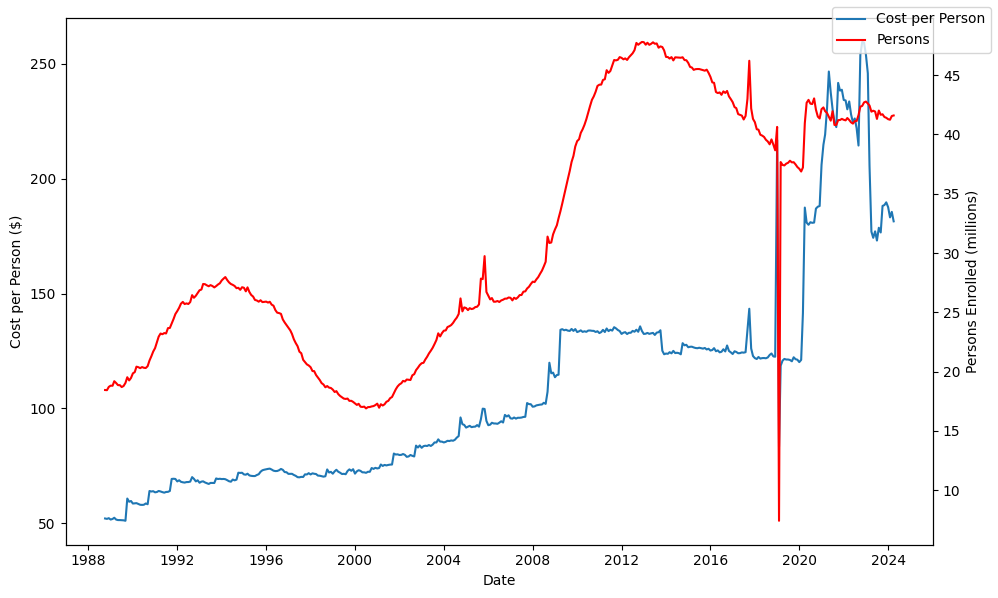

In [82]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(national_snap.index, national_snap['Benefit / Persons'], label = 'Cost per Person')
ax1.set_ylabel('Cost per Person ($)')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(national_snap.index, national_snap['Persons'] / 1e6, label = 'Persons', color='red')

ax2.set_ylabel('Persons Enrolled (millions)')

fig.legend()
fig.tight_layout()
plt.show()

### Obesity Comparisons

In [107]:
obesity_1 = pd.read_csv('../national_obesity_data/grouped_data_1.csv').set_index('YearStart')
obesity_2 = pd.read_csv('../national_obesity_data/grouped_data_2.csv').set_index('YearStart')
obesity_3 = pd.read_csv('../national_obesity_data/grouped_data_3.csv').set_index('YearStart')
obesity_4 = pd.read_csv('../national_obesity_data/grouped_data_4.csv').set_index('YearStart')


In [106]:
filtered_by_year = national_snap.copy()
filtered_by_year['Year'] = filtered_by_year.index.year
filtered_by_year = filtered_by_year.groupby('Year').mean()

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_27508/3665887563.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered_by_year = filtered_by_year.groupby('Year').mean()


In [100]:
filtered_by_year

Index(['YearStart', 'Households', 'Persons', 'Benefit / Households',
       'Benefit / Persons', 'Cost'],
      dtype='object')

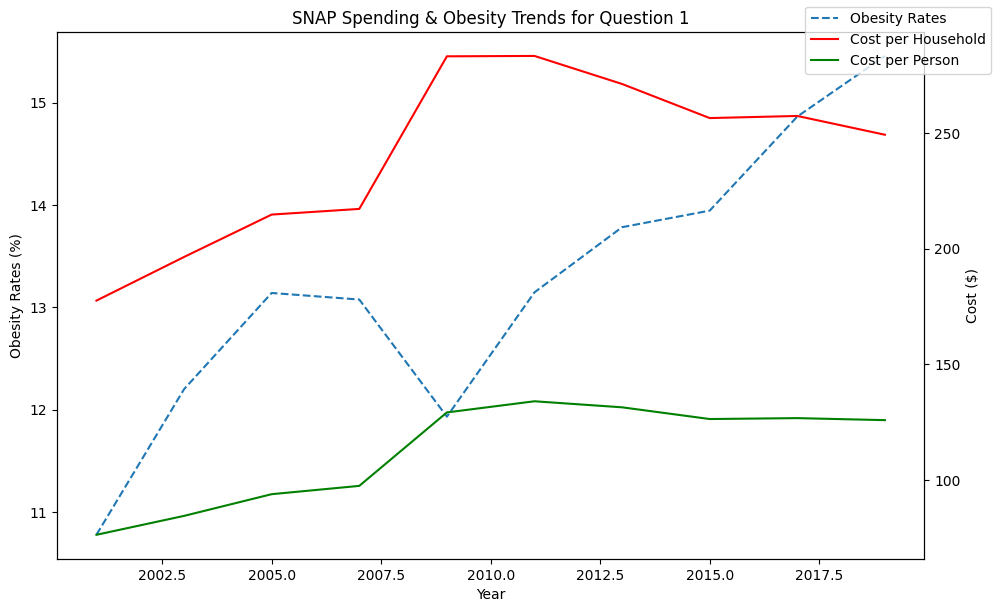

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_27508/2867036239.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = grouped.corr()


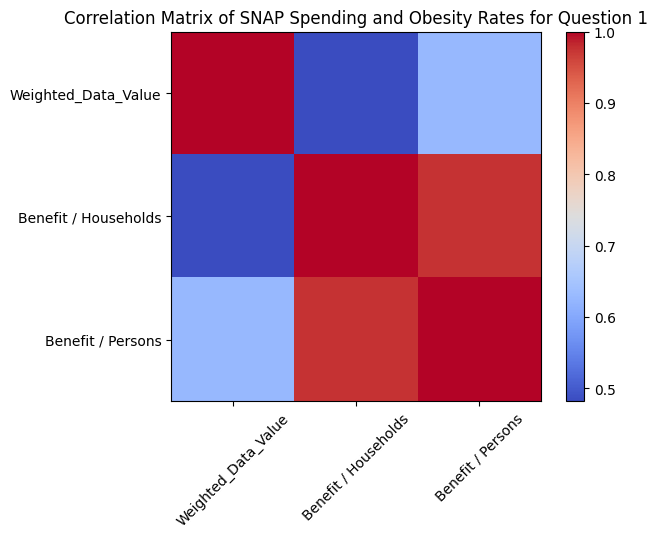

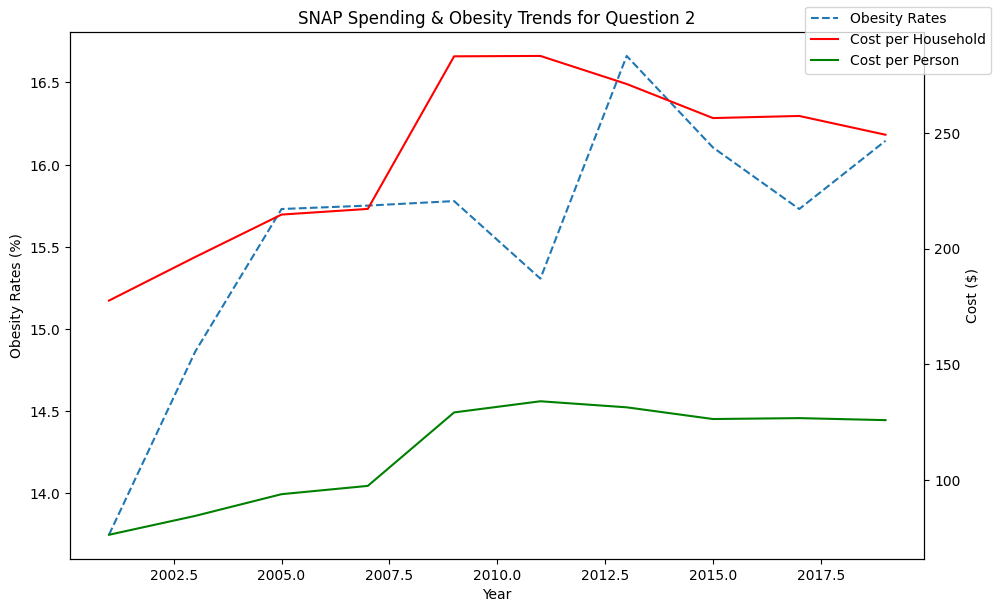

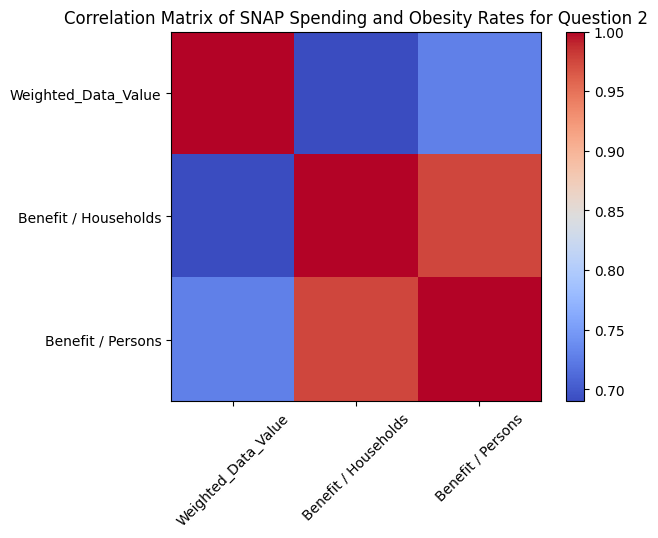

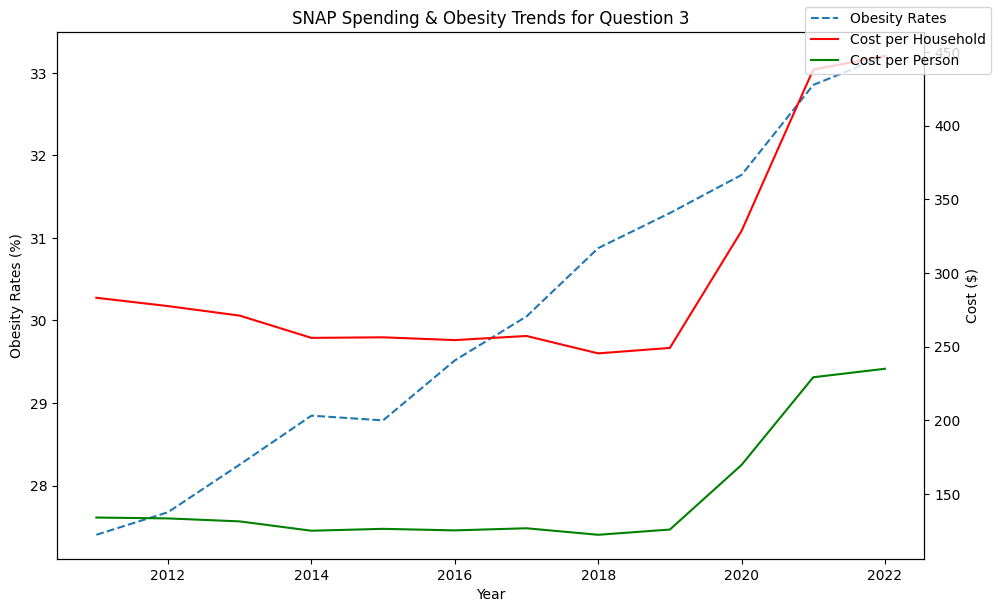

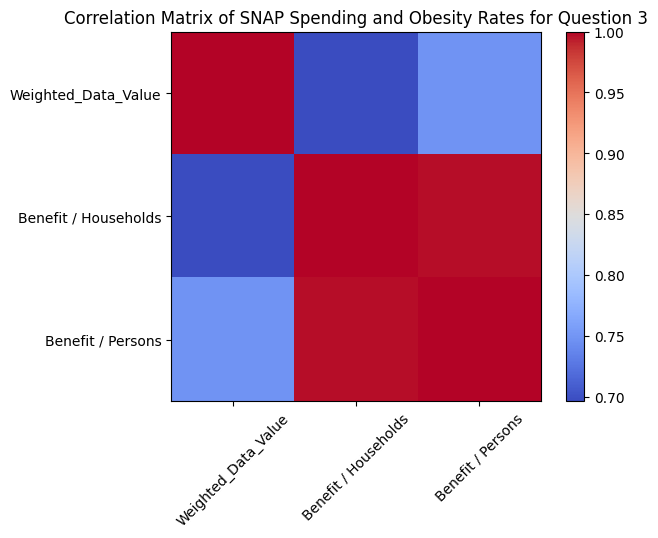

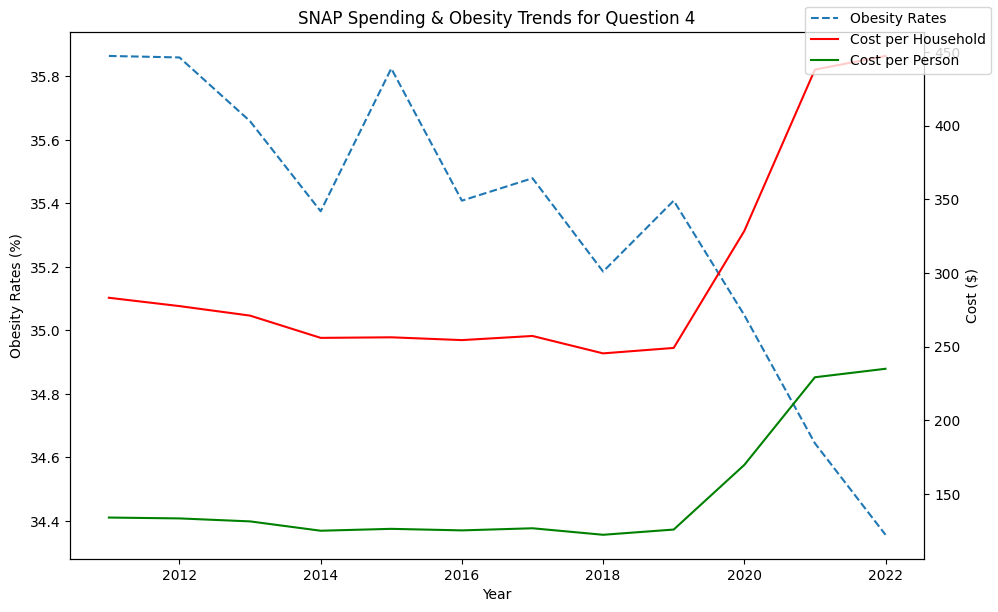

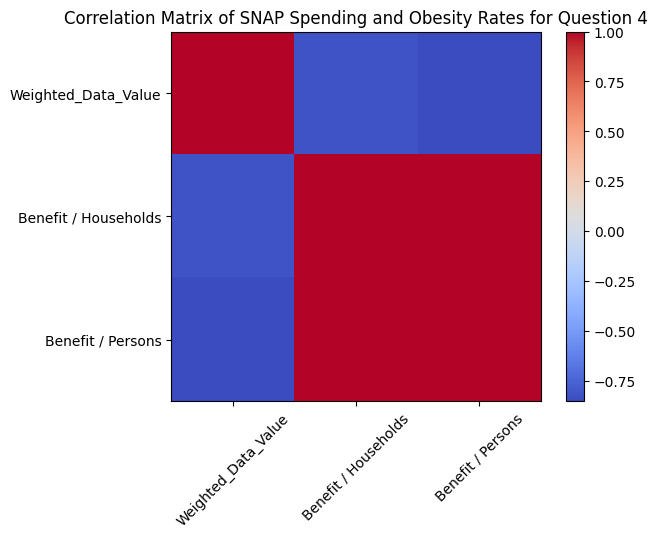

In [123]:
for i, grouped in enumerate([obesity_1, obesity_2, obesity_3, obesity_4]):
    grouped['Benefit / Households'] = filtered_by_year['Benefit / Households']
    grouped['Benefit / Persons'] = filtered_by_year['Benefit / Persons']

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(grouped.index, grouped['Weighted_Data_Value'], label = 'Obesity Rates', linestyle='--')
    ax1.set_ylabel('Obesity Rates (%)')
    ax1.set_xlabel('Year')

    ax2 = ax1.twinx()
    ax2.plot(grouped.index, grouped['Benefit / Households'], label = 'Cost per Household', color='red')
    ax2.plot(grouped.index, grouped['Benefit / Persons'], label = 'Cost per Person', color='green')

    ax2.set_ylabel('Cost ($)')
    fig.legend()
    fig.tight_layout()
    plt.title(f'SNAP Spending & Obesity Trends for Question {i+1}')

    plt.show()

    corr = grouped.corr()
    plt.imshow(corr, cmap='coolwarm')
    variables = corr.columns

    plt.xticks(range(len(variables)), variables, rotation=45)
    plt.yticks(range(len(variables)), variables)
    plt.colorbar()

    plt.title(f'Correlation Matrix of SNAP Spending and Obesity Rates for Question {i+1}')

    plt.show()

,LocationDesc,Weighted_Data_Value,Benefit / Households,Benefit / Persons
YearStart,,,,
2011,National,27.403164,283.178025,134.009417
2012,National,27.676900,277.526517,133.422325
2013,National,28.253890,271.065208,131.397608
2014,National,28.846556,255.962483,125.062058
2015,National,28.789366,256.340992,126.338875
2016,National,29.515772,254.447550,125.296117
2017,National,30.048435,257.250842,126.729158
2018,National,30.876317,245.435758,122.312683
2019,National,31.302005,249.138958,125.859058


## State-Level Data

In [31]:
old_snap = process_snap('../SNAP_data')
old_snap.Date.max()

Timestamp('2024-04-01 00:00:00')

In [32]:
old_snap.sort_values(['Region', 'State', 'Date'], inplace=True)
old_snap.reset_index(drop=True, inplace=True)

In [33]:
old_snap[old_snap['Region'] == 'SWRO']

,Date,Households,Persons,Benefit / Households,Benefit / Persons,Cost,State,Region
16562,2016-10-01,429148.0,963303.0,273.4018,121.7995,117329819.0,Arizona,SWRO
16563,2016-11-01,426220.0,955392.0,271.9763,121.3342,115921737.0,Arizona,SWRO
16564,2016-12-01,422847.0,945941.0,271.0718,121.1724,114621916.0,Arizona,SWRO
16565,2017-01-01,417681.0,932091.0,269.9960,120.9884,112772184.0,Arizona,SWRO
16566,2017-02-01,409928.0,913814.0,267.8745,120.1659,109809248.0,Arizona,SWRO
...,...,...,...,...,...,...,...,...
18874,2023-12-01,82729.0,164522.0,386.8503,194.5256,32003736.0,Utah,SWRO
18875,2024-01-01,84021.0,166526.0,382.0225,192.7502,32097915.0,Utah,SWRO
18876,2024-02-01,80425.0,167803.0,402.7730,193.0420,32393021.0,Utah,SWRO
18877,2024-03-01,86184.0,170844.0,384.5823,194.0065,33144842.0,Utah,SWRO


In [8]:
region_map = {}
for region in old_snap.Region.unique():
    region_map[region] = old_snap[old_snap['Region'] == region]['State'].unique().tolist()

region_map

{'MARO': ['Delaware',
  'District of Columbia',
  'Maryland',
  'New Jersey',
  'Pennsylvania',
  'Virgin Islands',
  'Virginia',
  'West Virginia'],
 'MPRO': ['Colorado',
  'Iowa',
  'Kansas',
  'Missouri',
  'Montana',
  'Nebraska',
  'North Dakota',
  'South Dakota',
  'Utah',
  'Wyoming'],
 'MWRO': ['Illinois',
  'Indiana',
  'Iowa',
  'Michigan',
  'Minnesota',
  'Ohio',
  'Wisconsin'],
 'NERO': ['Connecticut',
  'Maine',
  'Massachusetts',
  'New Hampshire',
  'New York',
  'Rhode Island',
  'Vermont',
  'Virgin Islands'],
 'SERO': ['Alabama',
  'Florida',
  'Georgia',
  'Kentucky',
  'Mississippi',
  'North Carolina',
  'South Carolina',
  'Tennessee'],
 'SWRO': ['Arizona',
  'Arkansas',
  'Louisiana',
  'New Mexico',
  'Oklahoma',
  'Texas',
  'Utah'],
 'SWRO ': ['Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma', 'SWRO', 'Texas'],
 'WRO': ['Alaska',
  'Arizona',
  'California',
  'Guam',
  'Hawaii',
  'Idaho',
  'Nevada',
  'Oregon',
  'Washington']}

In [141]:
old_snap['State'].unique()

array(['Delaware', 'District of Columbia', 'Maryland', 'New Jersey',
       'Pennsylvania', 'Virgin Islands', 'Virginia', 'West Virginia',
       'Colorado', 'Iowa', 'Kansas', 'Missouri', 'Montana', 'Nebraska',
       'North Dakota', 'South Dakota', 'Utah', 'Wyoming', 'Illinois',
       'Indiana', 'Michigan', 'Minnesota', 'Ohio', 'Wisconsin',
       'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
       'New York', 'Rhode Island', 'Vermont', 'Alabama', 'Florida',
       'Georgia', 'Kentucky', 'Mississippi', 'North Carolina',
       'South Carolina', 'Tennessee', 'Arizona', 'Arkansas', 'Louisiana',
       'New Mexico', 'Oklahoma', 'Texas', 'SWRO', 'Alaska', 'California',
       'Guam', 'Hawaii', 'Idaho', 'Nevada', 'Oregon', 'Washington'],
      dtype=object)

In [142]:
old_snap.to_csv('../SNAP_data/processed_snap.csv', index=False)

In [170]:
national_snap = old_snap.groupby('Date').sum().reset_index()
#national_snap['Cost'] = national_snap['Cost'] / 1e6
national_snap['Benefit / Households'] = national_snap['Cost'] / national_snap['Households']
national_snap['Benefit / Persons'] = national_snap['Cost'] / national_snap['Persons']
#national_snap['Households'] = national_snap['Households'] / 1e3
#national_snap['Persons'] = national_snap['Persons'] / 1e6

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_10246/2026866261.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  national_snap = old_snap.groupby('Date').sum().reset_index()


In [149]:
national_snap[national_snap.Date.dt.year == 2019]

,Date,Households,Persons,Benefit / Households,Benefit / Persons,Cost
363,2019-01-02,20438289.0,40627707.0,24533.3869,11990.0041,8808.799831
364,2019-02-02,3695943.0,7422273.0,21216.1441,9761.5309,619.366211
365,2019-03-01,18942667.0,37664927.0,13111.5720,6465.7914,4466.551286
366,2019-04-01,18844455.0,37422372.0,13197.2303,6499.9296,4520.914707
367,2019-05-01,18833780.0,37381135.0,13233.4371,6521.1434,4543.639171
368,2019-06-01,18973316.0,37532817.0,13222.9039,6519.1588,4552.219037
369,2019-07-01,19026938.0,37602856.0,13250.4175,6528.8042,4560.929145
370,2019-08-01,19120797.0,37777171.0,13227.7922,6522.4342,4574.660707
371,2019-09-01,19081687.0,37637717.0,13162.9847,6496.4812,4536.128882
372,2019-10-01,19114619.0,37652952.0,13327.6810,6590.8540,4603.518956


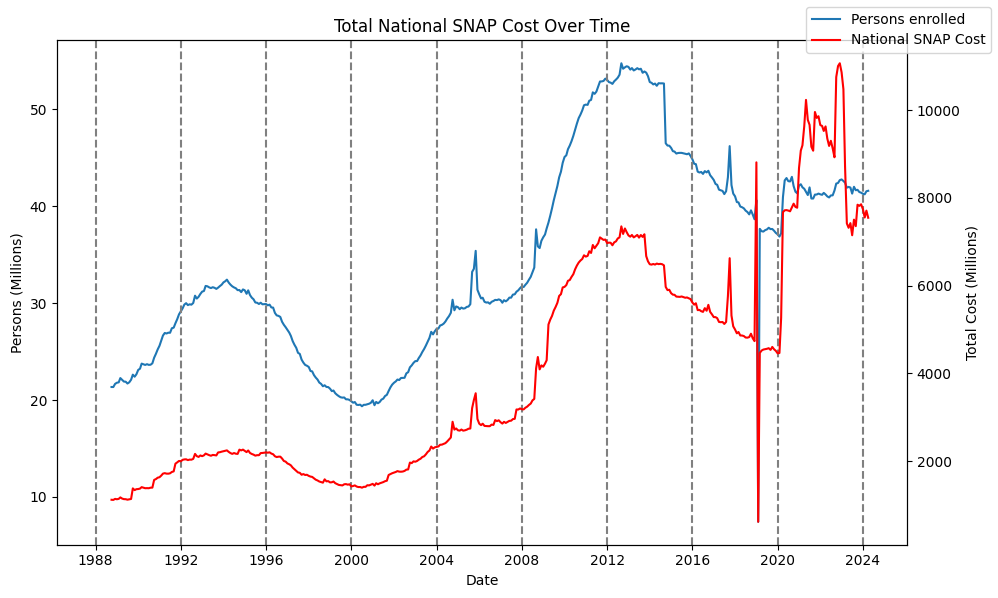

In [174]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(national_snap['Date'], national_snap['Persons'] / 1e6, label='Persons enrolled')
ax1.set_title('Total National SNAP Cost Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Persons (Millions)')

for year in range(1988, 2028, 4):
    ax1.axvline(pd.to_datetime(str(year) + '-01-01'), color='gray', linestyle='--')

ax2.plot(national_snap['Date'], national_snap['Cost'] / 1e6, label='National SNAP Cost', color='red')
ax2.set_ylabel('Total Cost (Millions)')

fig.legend()
plt.tight_layout()
plt.show()

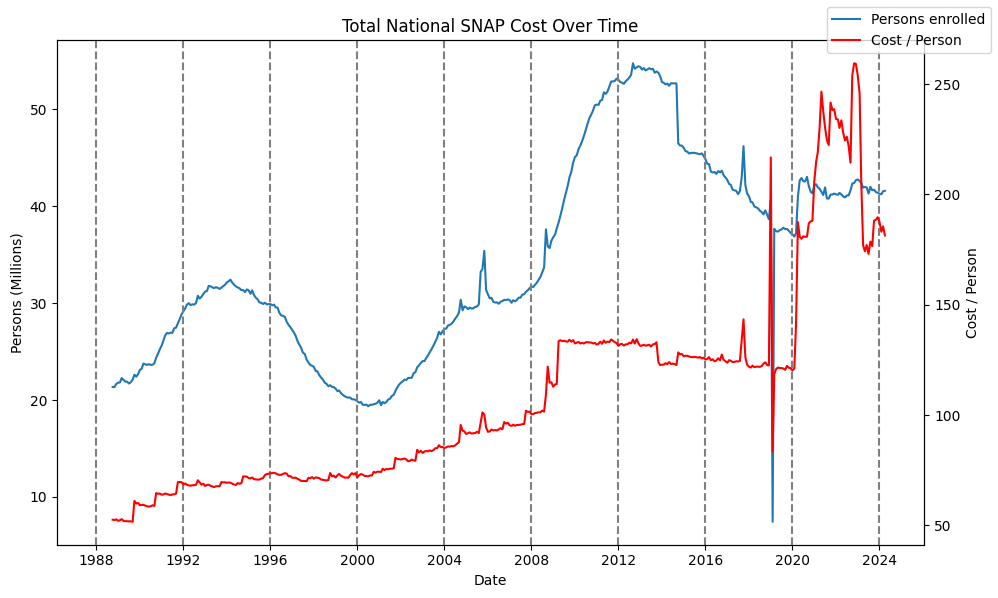

In [173]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(national_snap['Date'], national_snap['Persons'] / 1e6, label='Persons enrolled')
ax1.set_title('Total National SNAP Cost Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Persons (Millions)')

for year in range(1988, 2028, 4):
    ax1.axvline(pd.to_datetime(str(year) + '-01-01'), color='gray', linestyle='--')

ax2.plot(national_snap['Date'], national_snap['Benefit / Persons'], label='Cost / Person', color='red')
ax2.set_ylabel('Cost / Person')

fig.legend()
plt.tight_layout()
plt.show()

In [180]:
most_recent = old_snap[old_snap.Date == old_snap.Date.max()]
most_recent

,Date,Households,Persons,Benefit / Households,Benefit / Persons,Cost,State,Region
426,2024-04-01,5.828200e+04,1.098310e+05,367.1786,194.8440,2.139991e+07,Delaware,MARO
853,2024-04-01,8.552400e+04,1.359770e+05,311.2492,195.7631,2.661928e+07,District of Columbia,MARO
1280,2024-04-01,3.846280e+05,6.958590e+05,310.2178,171.4693,1.193185e+08,Maryland,MARO
1707,2024-04-01,4.408120e+05,8.383680e+05,349.4301,183.7295,1.540330e+08,New Jersey,MARO
2134,2024-04-01,1.093419e+06,2.013612e+06,326.6400,177.3700,3.571544e+08,Pennsylvania,MARO
2897,2024-04-01,4.251710e+05,8.292270e+05,344.3576,176.5631,1.464109e+08,Virginia,MARO
3324,2024-04-01,1.489200e+05,2.782650e+05,323.9587,173.3740,4.824392e+07,West Virginia,MARO
3751,2024-04-01,3.125670e+05,5.844160e+05,320.5503,171.4420,1.001935e+08,Colorado,MPRO
4514,2024-04-01,9.253600e+04,1.866010e+05,364.9894,180.9993,3.377466e+07,Kansas,MPRO
4941,2024-04-01,3.206610e+05,6.506130e+05,394.2301,194.3002,1.264142e+08,Missouri,MPRO


In [183]:
averages_most_recent = most_recent.groupby('Region').mean().reset_index()
averages_most_recent['Benefit / Households'] = averages_most_recent['Cost'] / averages_most_recent['Households']
averages_most_recent['Benefit / Persons'] = averages_most_recent['Cost'] / averages_most_recent['Persons']

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_10246/2558730190.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages_most_recent = most_recent.groupby('Region').mean().reset_index()


,Region,Households,Persons,Benefit / Households,Benefit / Persons,Cost
0,MARO,376679.428571,7.001627e+05,331.156836,178.158541,1.247400e+08
1,MPRO,115112.625000,2.265666e+05,360.871171,183.349281,4.154083e+07
2,MWRO,513308.857143,9.752643e+05,347.964927,183.143668,1.786135e+08
3,NERO,363288.053313,6.160709e+05,326.924525,192.782625,1.187678e+08
4,SERO,556342.125000,1.086309e+06,340.482318,174.374622,1.894247e+08
5,SWRO,447026.774443,9.248436e+05,376.052600,181.766489,1.681056e+08
6,WRO,570479.476813,9.949447e+05,317.364878,181.970059,1.810501e+08


In [185]:
pa_obesity = pd.read_csv('../Datathon_Data/Nutrition_Physical_Activity_and_Obesity_Data.csv')

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_10246/3523109882.py:1: DtypeWarning: Columns (18,19,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  pa_obesity = pd.read_csv('../Datathon_Data/Nutrition_Physical_Activity_and_Obesity_Data.csv')


In [238]:
pa_obesity[pa_obesity['Topic'].str.contains('Obesity')]['Question'].unique()

array(['Percent of students in grades 9-12 who have obesity',
       'Percent of students in grades 9-12 who have an overweight classification',
       'Percent of adults aged 18 years and older who have obesity',
       'Percent of adults aged 18 years and older who have an overweight classification'],
      dtype=object)

In [236]:
pa_overweight = pa_obesity[pa_obesity['Question'].str.contains('overweight')]

In [239]:
pa_overweight['Date'].unique()

array(['Percent of students in grades 9-12 who have an overweight classification',
       'Percent of adults aged 18 years and older who have an overweight classification'],
      dtype=object)

In [209]:
youth_obesity = pa_obesity[(pa_obesity['Topic'] == 'Obesity / Weight Status') & (pa_obesity['Datasource'] == 'Youth Risk Behavior Surveillance System') & (pa_obesity['Question'].str.contains('obesity'))][['YearStart', 'LocationDesc', 'Data_Value']]

In [210]:
#youth_obesity = youth_obesity[['YearStart', 'LocationAbbr', 'Data_Value']]
youth_obesity.dropna(inplace=True)

In [219]:
comp = (set(old_snap['State'].unique()) & set(youth_obesity['LocationDesc'].unique()))

In [232]:
youth_obesity.sort_values(by=['LocationDesc', 'YearStart'], inplace=True)
youth_obesity['YearStart'] = pd.to_datetime(youth_obesity['YearStart'], format='%Y')

In [223]:
nc_obesity = youth_obesity[youth_obesity['LocationDesc'] == 'North Carolina']
nc_snap = old_snap[old_snap['State'] == 'North Carolina']

In [225]:
nc_obesity['YearStart'] = pd.to_datetime(nc_obesity['YearStart'], format='%Y')

/var/folders/ld/qvd3psnd7j5d55kqqx7m2yfr0000gn/T/ipykernel_10246/1123991485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nc_obesity['YearStart'] = pd.to_datetime(nc_obesity['YearStart'], format='%Y')


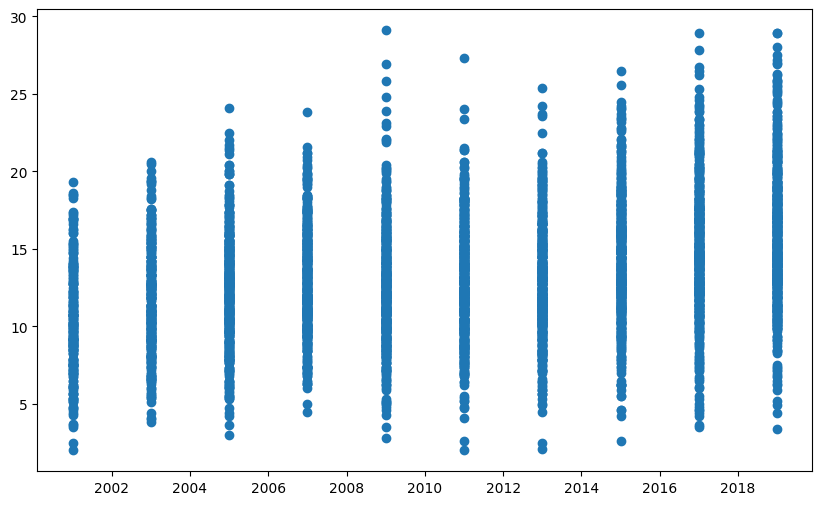

In [233]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.scatter(youth_obesity['YearStart'], youth_obesity['Data_Value'], label='Obesity Rate')
#ax2 = ax1.twinx()
#ax2.plot(nc_snap['Date'], nc_snap['Persons'] / 1e6, label='Persons Enrolled')